In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re

# Load the updated labeled data
df = pd.read_csv('data/labeled_reviews.csv')

# Remove Neutral class
df = df[df['predicted_label'] != 'Neutral']
print(f"After removing Neutral class: {len(df)} reviews")

# Check the new distribution
print("\nNew class distribution:")
class_counts = df['predicted_label'].value_counts()
print(class_counts)


After removing Neutral class: 314440 reviews

New class distribution:
predicted_label
Positive           236957
Negative            39161
Bug Report          16033
Spam                12240
Feature Request     10049
Name: count, dtype: int64


Preprocessing text...
After cleaning: 314439 reviews

Class distribution after cleaning:
predicted_label
Positive           236956
Negative            39161
Bug Report          16033
Spam                12240
Feature Request     10049
Name: count, dtype: int64


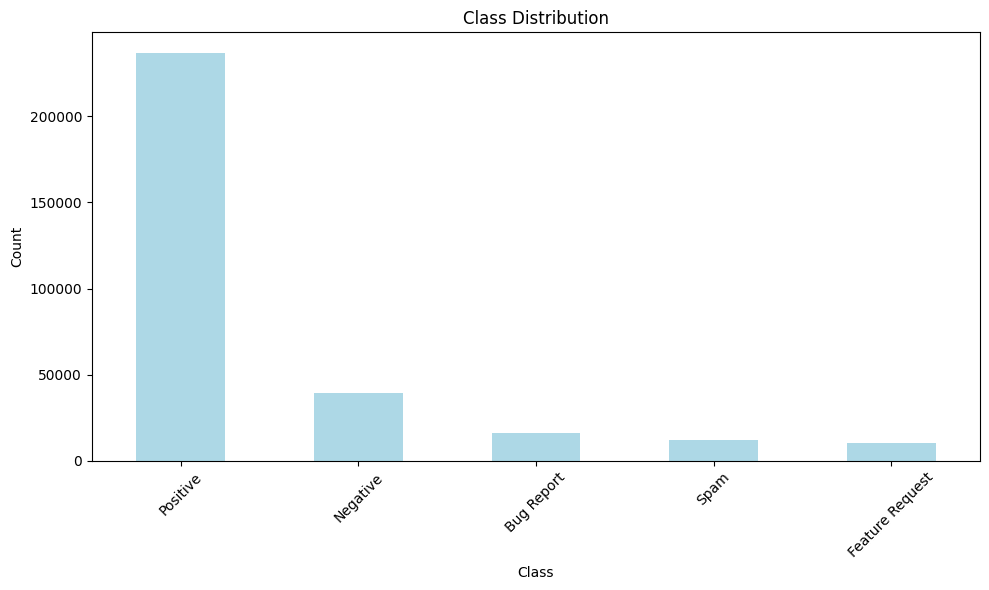

In [8]:
# Text preprocessing function
def preprocess_text(text):
    """Clean and preprocess text for modeling"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and extra whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing
print("Preprocessing text...")
df['cleaned_text'] = df['review_text'].apply(preprocess_text)

# Remove rows with empty text after cleaning
df = df[df['cleaned_text'].str.len() > 0]
print(f"After cleaning: {len(df)} reviews")

# Check for class imbalance
print("\nClass distribution after cleaning:")
class_counts = df['predicted_label'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='lightblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Prepare features and target
X = df['cleaned_text']
y = df['predicted_label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Convert text to TF-IDF features
print("\nConverting text to TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit features to prevent overfitting
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Minimum document frequency
    max_df=0.95  # Maximum document frequency
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

Training set: 251551 samples
Test set: 62888 samples

Converting text to TF-IDF features...
TF-IDF features shape: (251551, 5000)
Vocabulary size: 5000


In [10]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)

print("Model training completed!")

Training Logistic Regression model...
Model training completed!


=== MODEL EVALUATION ===

Classification Report:
                 precision    recall  f1-score   support

     Bug Report       0.98      0.96      0.97      3207
Feature Request       0.84      0.91      0.87      2010
       Negative       0.62      0.85      0.72      7832
       Positive       0.98      0.83      0.90     47391
           Spam       0.30      0.76      0.43      2448

       accuracy                           0.84     62888
      macro avg       0.74      0.86      0.78     62888
   weighted avg       0.90      0.84      0.86     62888


Confusion Matrix:
[[ 3085    37    50    17    18]
 [    3  1837    91    64    15]
 [    7    51  6679   541   554]
 [    9   238  3879 39445  3820]
 [   57    34   139   362  1856]]


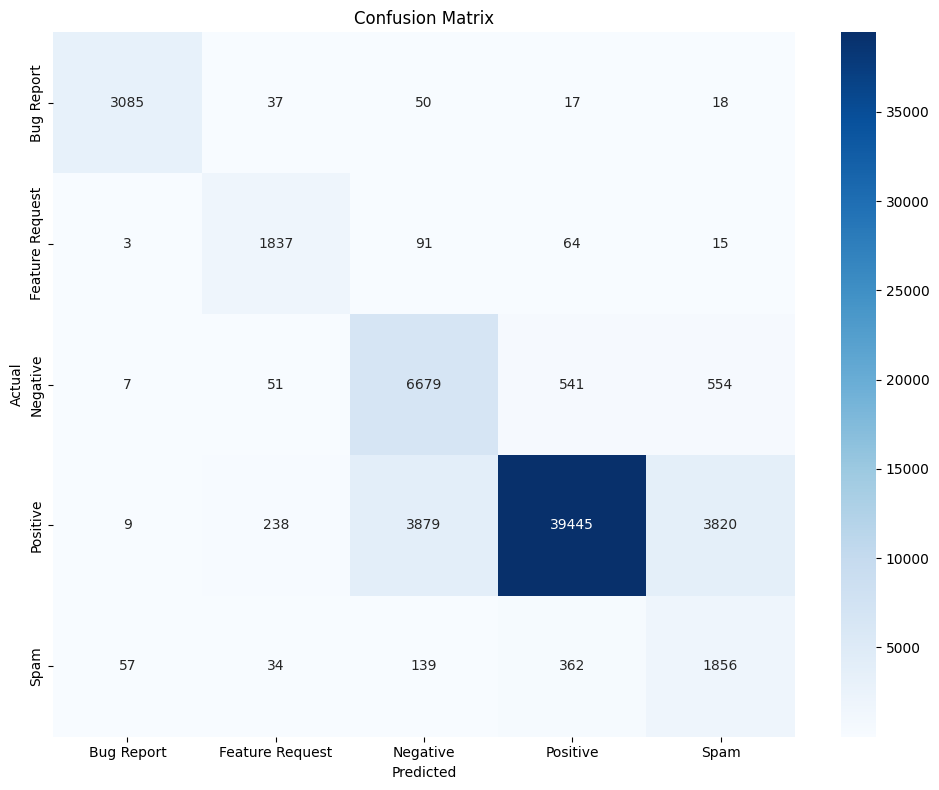


=== TOP FEATURES BY CLASS ===

Bug Report: doesn work, crashes, bugs, not working, problems, bug, error, issues, issue, problem

Feature Request: would like, suggestions, address, missing, wish, options, feature, add, option, features

Negative: ridiculous, cannot, disgusting, never, battery, useless app, permissions, not useful, uninstalling, uninstalled

Positive: helpfull, awesome, love this, helpful, owner, professional, excellent, good, great, not bad

Spam: freezing, visit, clicked, freezes, downloading, clicking, downloaded, free, download, click


In [12]:
# Evaluate the model
print("=== MODEL EVALUATION ===")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature importance (top words for each class)
print("\n=== TOP FEATURES BY CLASS ===")
feature_names = tfidf.get_feature_names_out()

for i, class_name in enumerate(model.classes_):
    top_indices = np.argsort(model.coef_[i])[-10:]  # Top 10 features
    top_features = [feature_names[j] for j in top_indices]
    print(f"\n{class_name}: {', '.join(top_features)}")

In [13]:
# Save the model and vectorizer
import os

# Create models directory if it doesn't exist
os.makedirs('data/models', exist_ok=True)

# Save the model
joblib.dump(model, 'data/models/classifier_model.pkl')
joblib.dump(tfidf, 'data/models/tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully!")
print("Files saved:")
print("- data/models/classifier_model.pkl")
print("- data/models/tfidf_vectorizer.pkl")

# Test the saved model
print("\n=== TESTING SAVED MODEL ===")
loaded_model = joblib.load('data/models/classifier_model.pkl')
loaded_tfidf = joblib.load('data/models/tfidf_vectorizer.pkl')

# Test with a sample review
test_review = "This app keeps crashing when I try to open messages"
test_cleaned = preprocess_text(test_review)
test_features = loaded_tfidf.transform([test_cleaned])
prediction = loaded_model.predict(test_features)[0]
confidence = loaded_model.predict_proba(test_features).max()

print(f"Test review: '{test_review}'")
print(f"Predicted: {prediction}")
print(f"Confidence: {confidence:.2f}")

Model and vectorizer saved successfully!
Files saved:
- data/models/classifier_model.pkl
- data/models/tfidf_vectorizer.pkl

=== TESTING SAVED MODEL ===
Test review: 'This app keeps crashing when I try to open messages'
Predicted: Bug Report
Confidence: 1.00
